# Production-ready LLM applications

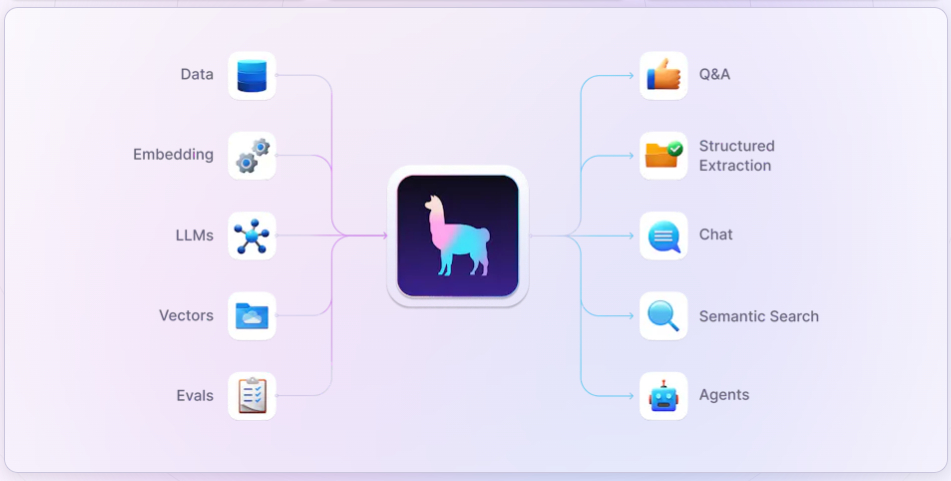

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install llama-index llama-index-llms-huggingface llama-index-embeddings-huggingface transformers accelerate bitsandbytes llama-index-readers-web matplotlib flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 58.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━

In [3]:
from llama_index.readers.web import BeautifulSoupWebReader

url = "https://www.theverge.com/2023/9/29/23895675/ai-bot-social-network-openai-meta-chatbots"

documents = BeautifulSoupWebReader().load_data([url])
documents

[Document(id_='https://www.theverge.com/2023/9/29/23895675/ai-bot-social-network-openai-meta-chatbots', embedding=None, metadata={'URL': 'https://www.theverge.com/2023/9/29/23895675/ai-bot-social-network-openai-meta-chatbots'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text="The synthetic social network is coming - The VergeSkip to main contentThe VergeThe Verge logo.The Verge homepageThe Verge homepageThe VergeThe Verge logo./Tech/Reviews/Science/Entertainment/AI/MoreMenuExpandThe VergeThe Verge logo.MenuExpandPlatformer/Artificial Intelligence/TechThe synthetic social network is comingThe synthetic social network is coming / Between ChatGPT’s surprisingly human voice and Meta’s AI characters, our feeds may be about to change foreverBy  Casey Newton, a contributing editor who has been writing about tech for over 10 years. He founded Platformer, a newsletter about Big Tech and democracy. Sep 29, 2023, 1:30 PM UTCShare this story Image: Álvaro Ber

In [4]:
#download Phi model
!huggingface-cli download microsoft/Phi-3-mini-4k-instruct-gguf Phi-3-mini-4k-instruct-q4.gguf --local-dir . --local-dir-use-symlinks False

/opt/conda/lib/python3.10/site-packages/huggingface_hub/commands/download.py:132: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Phi-3-mini-4k-instruct-q4.gguf: 100%|███████| 2.39G/2.39G [00:16<00:00, 143MB/s]
Download complete. Moving file to Phi-3-mini-4k-instruct-q4.gguf
Phi-3-mini-4k-instruct-q4.gguf


In [5]:
from llama_index.llms.huggingface import HuggingFaceLLM
import torch


def messages_to_prompt(messages):
    prompt = ""
    system_found = False
    for message in messages:
        if message.role == "system":
            prompt += f"<|system|>\n{message.content}<|end|>\n"
            system_found = True
        elif message.role == "user":
            prompt += f"<|user|>\n{message.content}<|end|>\n"
        elif message.role == "assistant":
            prompt += f"<|assistant|>\n{message.content}<|end|>\n"
        else:
            prompt += f"<|user|>\n{message.content}<|end|>\n"

    # trailing prompt
    prompt += "<|assistant|>\n"

    if not system_found:
        prompt = (
            "<|system|>\nYou are a helpful AI assistant.<|end|>\n" + prompt
        )

    return prompt




/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [6]:
llm = HuggingFaceLLM(
    model_name="microsoft/Phi-3-mini-4k-instruct",
    model_kwargs={
        "trust_remote_code": True,
        "torch_dtype": torch.bfloat16
    },
    generate_kwargs={"do_sample": True, "temperature": 0.1},
    tokenizer_name="microsoft/Phi-3-mini-4k-instruct",
    query_wrapper_prompt=(
        "<|system|>\n"
        "You are a helpful AI assistant.<|end|>\n"
        "<|user|>\n"
        "{query_str}<|end|>\n"
        "<|assistant|>\n"
    ),
    messages_to_prompt=messages_to_prompt,
    is_chat_model=True,
)
llm

config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


HuggingFaceLLM(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7f0252051a20>, system_prompt='', messages_to_prompt=<function messages_to_prompt at 0x7f0254ef9b40>, completion_to_prompt=<function default_completion_to_prompt at 0x7f02f618e200>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=PromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, template='<|system|>\nYou are a helpful AI assistant.<|end|>\n<|user|>\n{query_str}<|end|>\n<|assistant|>\n'), model_name='microsoft/Phi-3-mini-4k-instruct', context_window=3900, max_new_tokens=256, tokenizer_name='microsoft/Phi-3-mini-4k-instruct', device_map='auto', stopping_ids=[], tokenizer_outputs_to_remove=[], tokenizer_kwargs={'max_length': 3900}, model_kwargs={'trust_remote_code': True, 'torch_dtype': torch.bfloat16}, generat

In [7]:
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.llm = llm
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5")

Settings

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

_Settings(_llm=HuggingFaceLLM(callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7f0315377c70>, system_prompt='', messages_to_prompt=<function messages_to_prompt at 0x7f0254ef9b40>, completion_to_prompt=<function default_completion_to_prompt at 0x7f02f618e200>, output_parser=None, pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'>, query_wrapper_prompt=PromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['query_str'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, template='<|system|>\nYou are a helpful AI assistant.<|end|>\n<|user|>\n{query_str}<|end|>\n<|assistant|>\n'), model_name='microsoft/Phi-3-mini-4k-instruct', context_window=3900, max_new_tokens=256, tokenizer_name='microsoft/Phi-3-mini-4k-instruct', device_map='auto', stopping_ids=[], tokenizer_outputs_to_remove=[], tokenizer_kwargs={'max_length': 3900}, model_kwargs={'trust_remote_code': True, 'torch_dtype': torch.bfl

In [8]:
from llama_index.core import VectorStoreIndex

vector_index = VectorStoreIndex.from_documents(documents)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
vector_index

In [10]:
from llama_index.core import SummaryIndex

summary_index = SummaryIndex.from_documents(documents)

In [11]:
summary_index

In [12]:
from llama_index.core.response.notebook_utils import display_response

In [13]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [14]:
query_index = vector_index.as_query_engine(response_mode='compact')

response = query_index.query("How do OpenAI meta differ on AI tools?")

display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

You are not running the flash-attention implementation, expect numerical differences.


2024-06-11 19:35:28.297812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 19:35:28.297959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 19:35:28.533427: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**`Final Response:`** OpenAI and Meta differ in their approach to AI tools. OpenAI tends to present its products as productivity tools, focusing on simple utilities for getting things done, such as ChatGPT. On the other hand, Meta, which is in the entertainment business, has developed its own uses for generative AI and voices, including 28 personality-driven chatbots for its messaging apps, featuring voices from celebrities like Charli D'Amelio, Dwyane Wade, and others. While OpenAI emphasizes practical applications, Meta explores the potential for AI in entertainment and social networking.

In [15]:
query_index = vector_index.as_query_engine(response_mode='compact')

response = query_index.query("How do OpenAI meta differ on AI tools?")

display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**`Final Response:`** OpenAI and Meta differ in their approach to AI tools. OpenAI tends to present its products as productivity tools, focusing on simple utilities for getting things done. On the other hand, Meta, which is in the entertainment business, has developed its own uses for generative AI and voices, creating 28 personality-driven chatbots for its messaging apps. These chatbots feature voices from celebrities like Charli D'Amelio, Dwyane Wade, Kendall Jenner, MrBeast, Snoop Dogg, Tom Brady, and Paris Hilton. While OpenAI's ChatGPT is known for its language model capabilities, Meta's AI tools are more focused on providing engaging and entertaining interactions through personality-driven chatbots.

In [16]:
response = query_index.query("What is mention regarding a trans teenager?")
display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**`Final Response:`** In the provided context, a trans teenager is mentioned in an early episode of Hard Fork. The teenager sent in a voice memo to share their experience of using ChatGPT to receive daily affirmations about identity issues. The teenager highlighted the impact of giving text messages a warm and kindly voice, emphasizing the significance of this feature.

In [17]:
response = query_index.query("Which weekday was ChatGPT announced the last update?")
display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**`Final Response:`** Sept. 29, 2023

However, the specific weekday is not mentioned in the provided context. The announcement date is given as September 29, 2023, but without a specific day of the week, we cannot determine the exact weekday. If the context implies a specific day, it is not stated in the provided text.

In [18]:
query_engine = vector_index.as_query_engine(response_mode="refine")

response = query_engine.query("How do OpenAI and Meta differ on AI tools?")

display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**`Final Response:`** OpenAI and Meta have different approaches to their AI tools. OpenAI, the company behind ChatGPT, primarily presents its products as productivity tools, focusing on helping users accomplish tasks efficiently. On the other hand, Meta, formerly known as Facebook, has a dual emphasis on productivity and entertainment. They have developed personality-driven chatbots, including those voiced by celebrities, to enhance user interaction within their messaging apps. These chatbots aim to provide a unique experience by combining AI capabilities with familiar personas.

In [19]:
query_engine = vector_index.as_query_engine(response_mode="tree_summarize")

response = query_engine.query("Give me an overall summary of the article in bullet points")

display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**`Final Response:`** - The Verge discusses the rise of a synthetic social network, featuring AI-generated imagery and Meta's personality-driven chatbots.
- OpenAI's ChatGPT now offers voice-enabled interactions, adding personality and empathy to the AI's responses.
- Meta has developed 28 personality-driven chatbots for its messaging apps, featuring voices from celebrities like Charli D'Amelio, Dwyane Wade, and Tom Brady.
- The article explores the potential impact of these advancements on social media, questioning whether they will create more personalized, engaging, and entertaining experiences or feel uncanny and hollow.
- The Verge suggests that these AI-driven social networks could be a new era in consumer internet, with AI companions offering support, coaching, and entertainment.
- The article acknowledges that some may view these AI companions as a simulacrum of human experience, but it also recognizes the potential benefits for those who are lonely or isolated.
- OpenAI presents its products as productivity tools, while Meta focuses

In [20]:
query_engine = vector_index.as_query_engine(response_mode="tree_summarize")

response = query_engine.query("What is the webpage are you focus here?")

display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**`Final Response:`** The webpage being focused on in this context is from The Verge, a technology news website. The specific URL provided is: https://www.theverge.com/2023/9/29/23895675/ai-bot-social-network-openai-meta-chatbots. The article discusses the development of AI and the potential impact on social networks, with a particular focus on OpenAI's ChatGPT and Meta's AI characters.

In [21]:
query_engine = vector_index.as_query_engine(response_mode="tree_summarize")

response = query_engine.query("Can you use this model to read an online pdf")

display_response(response)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

**`Final Response:`** Based on the information provided, the AI model discussed in the article is ChatGPT, which is a large language model developed by OpenAI. ChatGPT is primarily designed for generating text-based responses and engaging in conversations. It does not have the capability to directly read or interpret online PDFs.

However, there are other tools and services available that can help you read and extract information from online PDFs, such as Adobe Acrobat Reader, Google Drive, or online PDF readers like Smallpdf or ILovePDF. These tools may utilize AI technology to assist in reading and understanding the content within PDFs, but they are not the same as the ChatGPT model.